<a href="https://colab.research.google.com/github/BenaribIlyes/Edge_computing/blob/main/code/edge_computing_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travaux Pratiques - N9EE39A Edge Computing
**Contact: Adrien THIRION ([email](adrien.thirion@nanomade.com))**  
**Créé en Octobre 2023**

L'objectif de ces séances de travaux pratiques est de vous familiariser avec le métier de Data Scientists, plus particulièrement dans un environnement contraint (système embarqué). Celui-ci a été pensé pour développer une vue d'ensemble de toutes les étapes nécessaires lors de la création d'un modèle, jusqu'à ce que celui-ci soit embarqué.

Comme tout bon data scientist, l'utilisation de fonction existante sur internet est vitale !! En effet, l'intelligence artificielle est très présent de nos jours, donc si vous avez un problème, il est presque assuré que quelqu'un ait déjà eu le même !

Le TP va se porter sur un sujet concret: la reconnaissance vocal. Ce sujet rentre dans le thème du Traitement automatique du langage naturel ou NLP [1]) où la demande en IA embarqué est très recherchée (ex. enceinte connecté, smartphone, smartwatches, ..). Pour cela, vous allez vous baser sur une base de données existante se trouvant Kaggle: the TensorFlow Speech Recognition Challenge. Kaggle est un site de competition permettant de récompenser les meilleurs modèles avec des prix décernés aux meilleurs modèles. Cette compétition a été organisée par Google, avec plus de 25 000$ à gagner. Certaines peuvent même dépasser le million de dollard (ex. Netflix Price) donc si vous avez soif d'argent ou que le l'IA vous plaît, allez y jeter un coup d'oeil !

Dans ce projet, vous allez essayer de classer correctement les 12 labels présents dans cette base de donnée via un modèle de convolution 1D ou récursif que vous aurez optimisé. Puis, vous devrez visualiser la variation des performances de ce modèle en fonction de son allégement (dans une volonté de l'embarquer).

Le Rapport devra être fait sur ce jupyter notebook, en Markdown (comme le texte que vous êtes en train de lire).

Ce projet a pour but d'évaluer votre esprit critique, votre analyse d'un problème et votre regard critique sur vos performances. Pour cela, l'entraide est encouragée mais en aucun cas le plagiat. Merci de respecter cela (promis c'est pour votre bien). Expliquez bien votre démarche et la raison de vos choix !!

Le projet sera découpé en 5 TPs de 4h. Un guide de progession sera affiché sur chaque partie pour connaître votre avancement.

Ce projet va être découpé en plusieurs parties:

1. L'Analyse de la base de donnée.
2. L'état de l'art.
3. Le Preprocessing.
4. L'apprentissage du modèle.
5. Les résultats et discussions.
6. L'allégement du modèle.
7. La conclusion.



# Analyse de la base de données 

La première étape est de télecharger et d'analyser la base de donnée. Pour cela rendez vous sur le site de la compétition:
https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge/overview

Pensez à bien regarder la compétition en détail, cela pourra vous être très utile (comme par exemple trouver du code ou des articles).

# Information sur la base de donnée

Tips: Parlez de tous ce que vous savez des données (quantité d'instances, les labels, la taille d'une time series, sa fréquence d'echantillonage, ...).

Le dossier contient trois fichiers principaux :
- Train.7z : Les données d'entraînement sont des enregistrements d'une seconde. La fréquence d'échantillonnage est de 16 KHz . Les labels à prédire sont : yes, no, up, down, left, right, on, off, stop, go.

-Test.7z : Contient un dossier de 150,000+ fichiers au format wav.

-Sample_submission.csv - Un exemple de rendu.
Visualitation d'une donnée et analyse critique

Tips: Faites un subplot de plusieurs labels différents pour voir visuellement les différences. 

# Visualitation d'une donnée et analyse critique

Tips: Faites un subplot de plusieurs labels différents pour voir visuellement les différences.

    Ecrire votre texte ici.



In [278]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from scipy.io import wavfile

In [279]:
#from google.colab import drive # Pour google colab
#drive.mount('/content/drive')  # Pour google colab

# Ajouter ce dossier dans votre drive: https://drive.google.com/drive/folders/1AAiaDTWJzvS6NaZXE_dfJ603QWhhcl0R?usp=sharing
# train_data_path = '/home/zebre/Bureau/IATI/3A/IA_et_materiel/edge_computing/Edge_computing/data/tensorflow-speech-recognition-challenge/train/audio'

In [280]:
#Pour utiliser le notebook en local

#Préciser le path des données d'entrainements
train_data_path = '/home/zebre/Bureau/edge_computing/Edge_computing/data/tensorflow-speech-recognition-challenge/train/audio'

#Préciser le path des données de test
test_data_path = '/home/zebre/Bureau/edge_computing/Edge_computing/data/tensorflow-speech-recognition-challenge/test/audio'


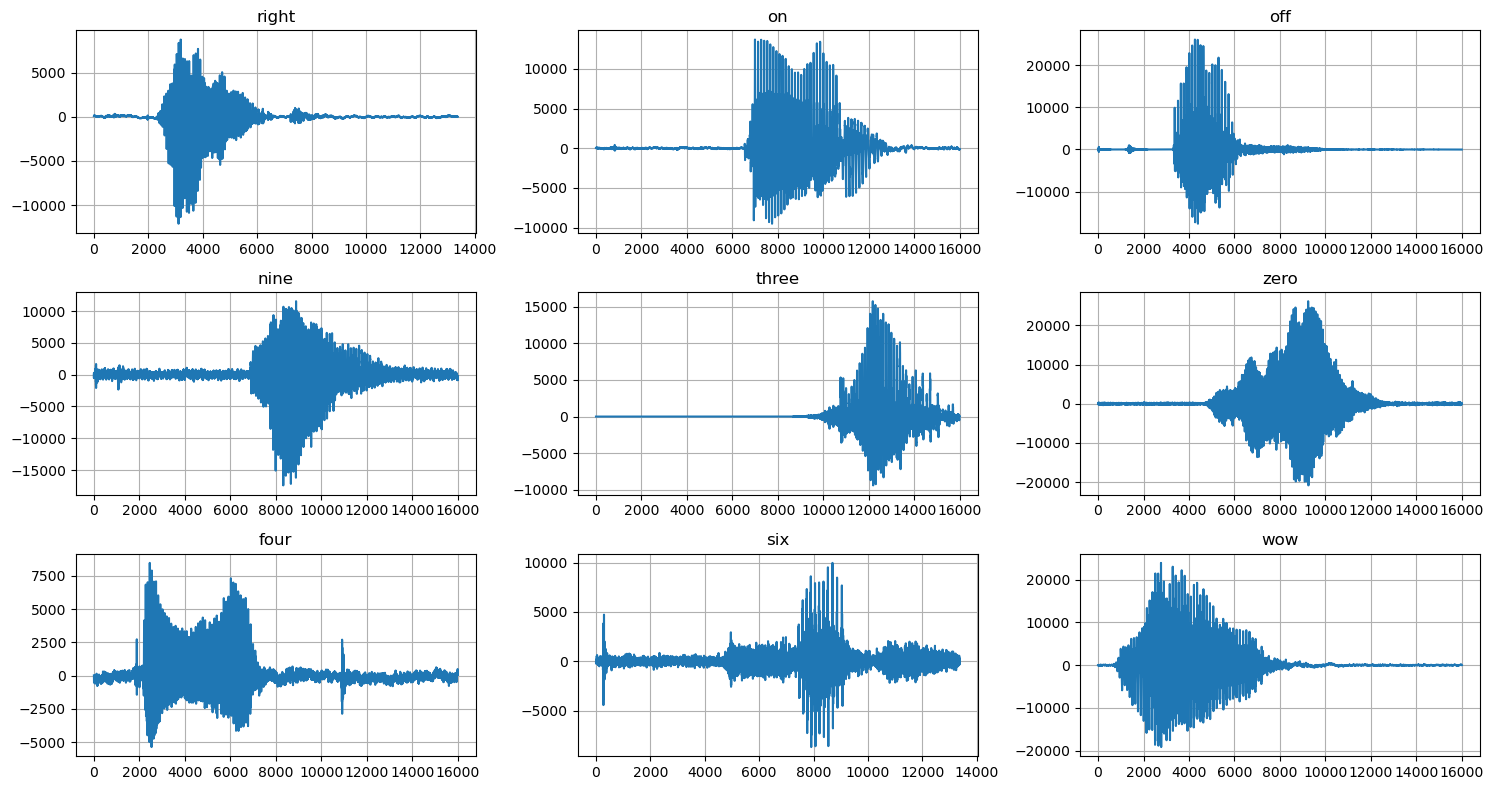

In [281]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Chemin vers les données

labels = os.listdir(train_data_path)[1:]  # On ignore le premier fichier

# Sélection aléatoire de 9 labels
Random_Labels = np.random.choice(labels, size=9, replace=False)

plt.figure(figsize=(15, 8))

for i, label in enumerate(Random_Labels, 1):
    wav_files_path = os.path.join(train_data_path, label)
    random_wav = np.random.choice(os.listdir(wav_files_path))  # un fichier wav aléatoire
    sr, time_series = wavfile.read(os.path.join(wav_files_path, random_wav))

    plt.subplot(3, 3, i)
    plt.plot(time_series)
    plt.grid()
    plt.title(label)

plt.tight_layout()
plt.show()


### Stockage des données
 <font color="red"> **ATTENTION:** Respectez l'ordre des labels: 0 = yes, 1 = no, 2 = up, 3 = down, 4 = left, 5 = right, 6 = on, 7 = off, 8 = stop, 9 = go, 10 = silence, 11 = unknown </font>

<font color=" Darkblue"> **Tips:** Réduisez la taille des données d'entrées afin d'éviter la saturation de la mémoire </font>

In [282]:
import os
import numpy as np
from scipy.io import wavfile

# Assurez-vous d'avoir bien importé os, numpy et wavfile (de scipy.io)

Data_Dict = {
      "yes": 0, "no": 1, "up": 2, "down": 3, "left": 4, "right": 5, 
      "on": 6, "off": 7, "stop": 8, "go": 9, "_background_noise_": 10, 
      "unknown": 11
  }
UNKNOWN_ID = Data_Dict["unknown"]

def import_data(max_files_per_label=100, data_path=train_data_path):
    all_waves, all_labels = [], []
    
    # ⭐ NOUVEAU : Compteur global pour les fichiers "unknown"
    unknown_count = 0 
    
    # Pour le suivi (debug)
    print(f"Démarrage de l'importation (max {max_files_per_label} par label ID)...")

    for folder_name in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder_name)
        if not os.path.isdir(folder_path):
            continue

        label_id = Data_Dict.get(folder_name, UNKNOWN_ID)
        wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
        
        files_to_process = []
        
        # 1. Logique de Limite de Fichiers
        if label_id == UNKNOWN_ID:
            # S'assurer que le quota "unknown" n'est pas déjà atteint
            remaining_slots = max_files_per_label - unknown_count
            
            if remaining_slots <= 0:
                # Quota "unknown" déjà plein, passer au dossier suivant
                continue
            
            # Ne prendre que le nombre de fichiers nécessaire pour atteindre la limite
            num_files = min(len(wav_files), remaining_slots)
            files_to_process = wav_files[:num_files]
            
            # Mettre à jour le compteur global
            unknown_count += num_files
            
        else:
            # Pour les classes connues (ID 0 à 10), la limite est appliquée PAR DOSSIER
            files_to_process = wav_files[:max_files_per_label]

        # print(f"  -> Dossier '{folder_name}' (ID {label_id}) : {len(files_to_process)} fichiers traités.")

        # 2. Traitement des Fichiers (Lecture, Padding, MFCC...)
        for wav_file in files_to_process:
            file_path = os.path.join(folder_path, wav_file)
            sr, samples = wavfile.read(file_path)

            # Fixer la durée à 1 seconde (16000 échantillons)
            if len(samples) > 16000:
                samples = samples[:16000]
            else:
                samples = np.pad(samples, (0, 16000 - len(samples)))

            all_waves.append(samples)
            all_labels.append(label_id)

    # Affichage du résultat final pour vérification
    print(f"\nImportation terminée.")
    print(f"Nombre total d'échantillons importés : {len(all_waves)}")
    print(f"Nombre de fichiers 'unknown' (ID {UNKNOWN_ID}) : {unknown_count}")
    
    return np.array(all_waves), np.array(all_labels)


In [285]:
all_waves,all_labels = import_data(max_files_per_label=100)


Démarrage de l'importation (max 100 par label ID)...

Importation terminée.
Nombre total d'échantillons importés : 1106
Nombre de fichiers 'unknown' (ID 11) : 100


/tmp/ipykernel_5474/3934264047.py:58: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, samples = wavfile.read(file_path)


In [286]:
# Affichage des tailles
print(f'Taille des données : {all_waves.shape}')
print(f'Taille des labels : {all_labels.shape} \n')

# Exemple de donnée
id_exemple = 34
Exemple = [all_waves[id_exemple], all_labels[id_exemple]]
print(f"Exemple d'échantillon de données : {Exemple[0]}")
print(f"Exemple d'échantillon de label : {Exemple[1]} \n ")

# Récupérer le nom du label à partir de son ID
label_nom = [k for k, v in Data_Dict.items() if v == Exemple[1]][0]
print(f"L'exemple est un enregistrement du label : {label_nom}")

# Lecture audio
ipd.Audio(Exemple[0], rate=16000)


Taille des données : (1106, 16000)
Taille des labels : (1106,) 

Exemple d'échantillon de données : [-25 -32 -31 ...  42  41  35]
Exemple d'échantillon de label : 1 
 
L'exemple est un enregistrement du label : no


## Etat de l'art

Etape importante qui suit: faire un état de l'art. Que cela soit pour innover, ou pour trouver une solution existante pertinente, faire un état de l'art scientifique est essentiel. Ici, vous devez chercher les articles liés à ce projet. Il faut pour cela remplir le tableau et bien marquer leurs références en dessous. De plus, un texte synthétique vous sera demandé pour expliquer selon vous, quels papiers sont les plus pertinants pour la suite de ce projet.

Attention: une analyse critique est nécessaire sur ces papiers (certain papiers peuvent avoir des biais cachés).

<font color="orange"> **Note anti-plagiat:** Au moins 2 références devraient être différente des autres binômes. </font>

&nbsp;


<font color="Darkred"> Progression du TP après cette partie (environ 2h):

&nbsp;

---

Le véritable état de l'art pour ce défi est construit autour de deux axes majeurs : la définition du jeu de données et la conception d'architectures optimisées pour les contraintes d'embarqué.

### Tableau Récapitulatif

| Article | Références | Preprocessing | Modèle | Solution Embarquée ? | Dataset utilisé | Performances (Baseline) |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Warden (2018) [1]** | [1] Speech Commands [cite: 1, 10] | Normalisation à 1 seconde, 16 KHz[cite: 1, 5]. Extraction de la section la plus forte pour l'alignement[cite: 1]. | CNN (Convolutional Neural Network) [cite: 1] – Inspiré de Sainath & Parada[cite: 1]. | **Oui, objectif principal.** Modèles petits, faible consommation d'énergie, minimisation des faux positifs[cite: 1]. | **Speech Commands Dataset v2** (105 829 énonciations de 35 mots)[cite: 1]. | **Top-One Accuracy : 88.2%** (Baseline CNN sur V2)[cite: 1]. |
| **Zhang et al. (2017) [2]** | [2] Hello Edge [cite: 2] | Conversion du signal audio en **représentations 2D** (Spectrogrammes ou Mel-Spectrogrammes)[cite: 2]. | **DS-CNN** (Depthwise Separable CNN) – Architecture la plus efficace pour les contraintes de taille et de performance[cite: 2]. | **Oui.** Comparaison de l'efficacité des architectures pour l'exécution sur microcontrôleurs (CMSIS-NN)[cite: 2, 8]. | Similaire à [1] (Speech Commands V1)[cite: 2]. | Meilleur équilibre entre précision et efficacité énergétique/taille du modèle[cite: 2]. |

---


## Références

Les références complètes (format IEEE) pour les sources utilisées dans cette analyse :

1.  P. Warden, "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition," *arXiv e-prints*, 2018, art. no. arXiv:1804.03209.
2.  Y. Zhang, N. Suda, L. Lai et V. Chandra, "Hello Edge: Keyword Spotting on Microcontrollers," *arXiv e-prints*, 2017, art. no. arXiv:1711.07128.
3.  (2018) Speech commands dataset version 2. [Online]. Available: http://download.tensorflow.org/data/speech_commands\_v0.02.tar.gz [cite: 1]
4.  (2017) Speech commands dataset version 1. [Online]. Available: http://download.tensorflow.org/data/speech\_commands\_v0.01.tar.gz [cite: 1]
5.  (2018) Linguistic data consortium. [Online]. Available: https://www.ldc.upenn.edu/ [cite: 1]
6.  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li, and L. Fei-Fei, "ImageNet: A Large-Scale Hierarchical Image Database," in CVPR09, 2009. [cite: 1]
7.  T. N. Sainath and C. Parada, "Convolutional Neural Networks for Small-Footprint Keyword Spotting," in Sixteenth Annual Conference of the International Speech Communication Association, 2015. [Online]. Available: https://www.isca-speech.org/archive/interspeech\_2015/papers/i15\_1478.pdf [cite: 1]
8.  L. Lai, N. Suda, and V. Chandra, "CMSIS-NN: Efficient Neural Network Kernels for Arm Cortex-M CPUs," ArXiv e-prints, Jan. 2018. [cite: 1]
9.  R. Tang and J. Lin, "Deep Residual Learning for Small-Footprint Keyword Spotting," ArXiv e-prints, Oct. 2017. [cite: 1]
10. S. Krishna Gouda, S. Kanetkar, D. Harrison, and M. K. Warmuth, "Speech Recognition: Keyword Spotting Through Image Recognition," ArXiv e-prints, Mar. 2018. [cite: 1]

## Preprocessing

C'est la partie la plus importante du projet !! Même le modèle le plus performant de la terre ne pourra pas être précis sans des données d'entrées propres. De plus, il est important de réduire la quantité de données d'entrée (Décimation) afin de ne pas avoir un modèle trop lourd.

<font color=" Darkblue"> **Tips:** Commencez par un preprocessing simple, et améliorez le lorsque les modèles seront en cours d'apprentissage. </font>

Voici quelques sources qui pourront vous être utile pour faire votre code, en plus de l'état de l'art précedemment fait:
- https://medium.com/enjoy-algorithm/pre-processing-of-time-series-data-c50f8a3e7a98
- https://monkeylearn.com/blog/data-preprocessing/
- https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html (pour les plus expérimenté d'entre vous)

&nbsp;

<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  
![56%](https://progress-bar.dev/56)


### Zone d'expérimentation

Ici vous êtes libre d'essayer des choses, les visualiser, avoir un regard critique sur la solution que vous décidez de prendre. Utilisez autant de cases de codes et de textes.

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def Transformations(transformer, num_points=120):
    """
    Met en évidence l'effet de 5 transformations :
     - Power Transform : rend la distribution plus normale
     - Difference Transform : stationnarise la série
     - Seasonal Transform : enlève la saisonnalité
     - Standardisation : moyenne=0, variance=1
     - Normalisation : valeurs entre 0 et 1
    """

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    if transformer == 'Power Transform':
        data = np.random.exponential(2.0, num_points)
        data_boxcox, λ = stats.boxcox(data)
        to_plot = [data, data_boxcox]
        titles = ['Raw Data', f'Power Transform (λ = {λ:.3f})']

    elif transformer == 'Difference Transform':
        t = np.arange(num_points)
        data = 0.5 * t + np.random.normal(0, 5, num_points)
        data_diff = np.diff(data, n=1)
        ax[0].plot(t, data); ax[0].set_title('Données brutes (avec tendance)')
        ax[1].plot(t[1:], data_diff); ax[1].set_title('Après différence (stationnaire)')
        for a in ax: a.grid()
        plt.show()
        return

    elif transformer == 'Seasonal Transform':
        # Série avec tendance et saisonnalité
        t = np.arange(num_points)
        period = 12
        data = 10 + 0.3*t + 5*np.sin(2*np.pi*t/period) + np.random.normal(0, 1, num_points)
        # Seasonal difference
        data_seasonal_diff = data[period:] - data[:-period]
        ax[0].plot(t, data); ax[0].set_title('Données brutes (avec saisonnalité)')
        ax[1].plot(t[period:], data_seasonal_diff); ax[1].set_title(f'Après différence saisonnière (période={period})')
        for a in ax: a.grid()
        plt.show()
        return

    elif transformer == 'Standardisation':
        data = 20 + np.sqrt(5) * np.random.normal(scale=5.0, size=(num_points, 1))
        data_trans = StandardScaler().fit_transform(data)
        to_plot = [data, data_trans]
        titles = ['Données brutes', 'Standardisées ']

    elif transformer == 'Normalisation':
        data = 20 + np.sqrt(5) * np.random.normal(scale=5.0, size=(num_points, 1))
        data_trans = MinMaxScaler().fit_transform(data)
        to_plot = [data, data_trans]
        titles = ['Données brutes', 'Normalisées [0,1]']

    else:
        raise ValueError("Transformer doit être l’un des suivants : "
                         "'Power Transform', 'Difference Transform', 'Seasonal Transform', 'Standardisation', 'Normalisation'.")

    # Affichage commun (histogrammes)
    for i, (d, title) in enumerate(zip(to_plot, titles)):
        ax[i].hist(d, bins=30, edgecolor='black')
        ax[i].set_title(title)
        ax[i].set_xlabel('Valeur')
        ax[i].set_ylabel('Fréquence')
        ax[i].grid()

    plt.tight_layout()
    plt.show()


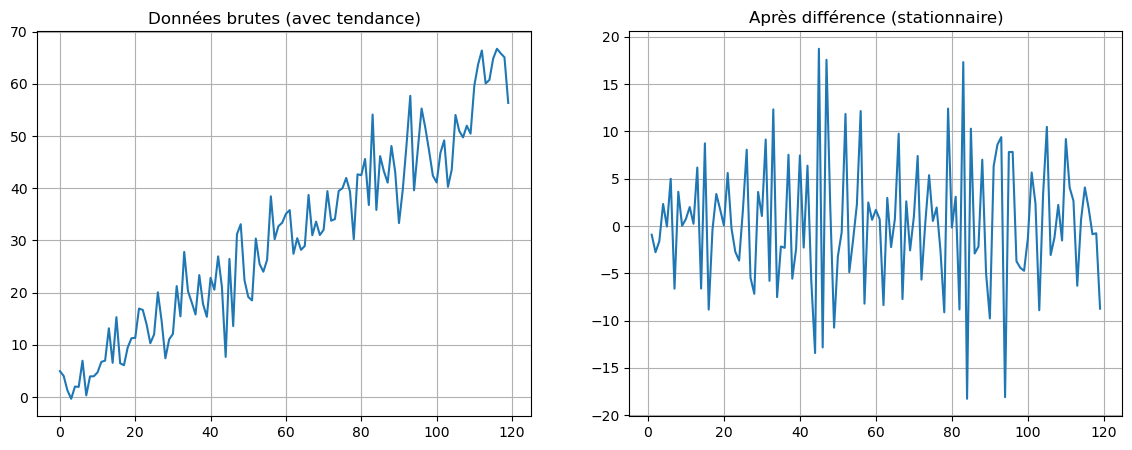

In [288]:
# Décommenter pour tester la transformation

#Transformations('Power Transform')
Transformations('Difference Transform')
#Transformations('Seasonal Transform')
#Transformations('Standardisation')
#Transformations('Normalisation')

**PS** : En général, l'ordre à suivre pour faire du preprocessing avec ces fonctions est : Power Transform, Seasonal Difference, Trend Difference,Standardization, Normalization.

In [289]:
# ===========================================================
# Fonctions de prétraitement audio (inspirées de la doc)
# ===========================================================

import numpy as np
from scipy.fftpack import dct

def To_normalize(signal):
    """"Normalise les données"""
    normalized_signal = MinMaxScaler().fit_transform(signal)
    return normalized_signal


def pre_emphasis_filter(signal, coefficient=0.97):
    """"Filtre numérique passe haut (dérivateur) amplififiant les hautes fréquence, fc = 100Hz (valeur classique)"""
    return signal - coefficient * np.roll(signal, 1)


def framing(signal, frame_length, frame_step, sample_rate):
    """Découpe le signal en trames de durée fixe (fenêtrage temporel)."""
    signal_length = len(signal)
    frame_length = int(round(frame_length * sample_rate))
    frame_step = int(round(frame_step * sample_rate))

    num_frames = int(np.floor((signal_length - frame_length) / frame_step)) + 1
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames


def window_hamming(frames):
    """Applique une fenêtre de Hamming pour lisser les trames."""
    frame_length = len(frames[0])
    windowed_frames = np.zeros(frames.shape)
    for i in range(len(frames)):
        windowed_frames[i] = frames[i] * np.hamming(frame_length)
    return windowed_frames


def fft(windowed_frames, NFFT=512):
    """Calcule le spectre de puissance de chaque trame (FFT)."""
    mag_frames = np.absolute(np.fft.rfft(windowed_frames, NFFT))
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
    return pow_frames


def filter_bank(pow_frames, sample_rate, NFFT=512, nfilt=40):
    """Applique un banc de filtres de Mel pour regrouper les fréquences."""
    low_freq_mel = 0
    high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)
    return filter_banks


def mfcc_coeffs(filter_banks, num_ceps=12, ceplifter=22):
    """Extrait les coefficients cepstraux MFCC à partir des filtres de Mel."""
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps + 1)]
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (ceplifter / 2) * np.sin(np.pi * n / ceplifter)
    mfcc *= lift
    return mfcc


def Mean_Norm(Data):
    """Centre les données (MFCC ou filter banks) autour de leur moyenne."""
    Mean_Data = np.zeros(Data.shape)
    for i in range(Data.shape[0]):
        Mean_Data[i] = Data[i] - np.mean(Data[i])
    return Mean_Data


Taille du signal :(16000,)
Taille du signal filtré :(16000,)
Taille des fenêtres :(98, 400)
Taille des fenêtres après hamming :(98, 400)
Taille des fenêtres après fft :(98, 257)
Taille du spectrogramme :(257, 98)
Taille des filter banks :(98, 40)
Taille des MFCCs :(98, 12)


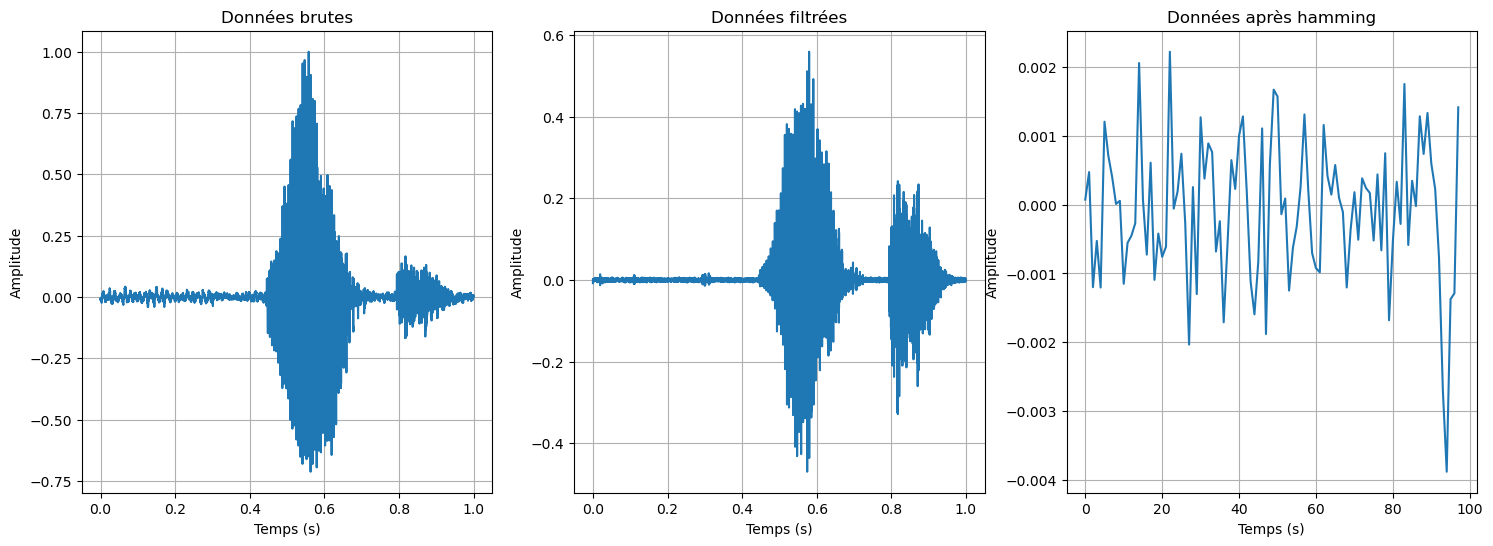

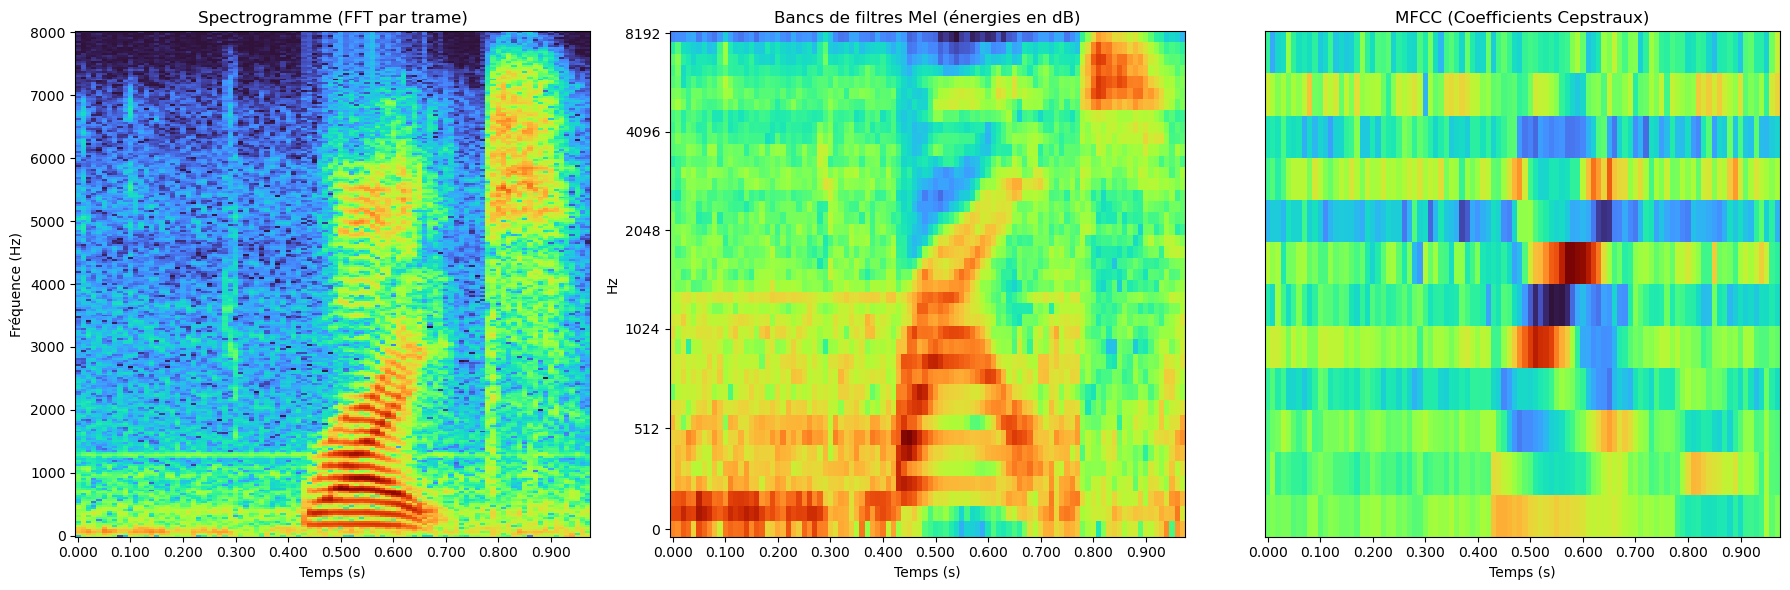

In [290]:
import librosa
import librosa.display

# Visualisation de l'effet des fonctions précédentes

# Chemin vers les données
labels = os.listdir(train_data_path)[1:]  # On ignore le premier fichier

# Sélection aléatoire d'un fichier wav
Random_Label = np.random.choice(labels, size=len(labels), replace=False)
wav_files_path = os.path.join(train_data_path, Random_Labels[0])
random_wav = np.random.choice(os.listdir(wav_files_path))  # un fichier wav aléatoire
sr, signal = wavfile.read(os.path.join(wav_files_path, random_wav))

# Application des transformations
signal = signal / np.max(np.abs(signal)) # Normalisation
emphasized_signal = pre_emphasis_filter(signal)
frames = framing(signal, frame_length=0.025, frame_step=0.01, sample_rate=sr) # fenêtres de 25ms
windowed_frames = window_hamming(frames)
pow_frames = fft(windowed_frames)
log_spectrogram = 10 * np.log10(pow_frames.T + 1e-8) # Pour la visualisation
filter_banks = filter_bank(pow_frames, sample_rate = sr)
filter_banks = Mean_Norm(filter_banks)
mfcc = mfcc_coeffs(filter_banks, num_ceps=12, ceplifter=22)
mfcc = Mean_Norm(mfcc)


# Débogage
print(f'Taille du signal :{signal.shape}')
print(f'Taille du signal filtré :{emphasized_signal.shape}')
print(f'Taille des fenêtres :{frames.shape}')
print(f'Taille des fenêtres après hamming :{windowed_frames.shape}')
print(f'Taille des fenêtres après fft :{pow_frames.shape}')
print(f'Taille du spectrogramme :{log_spectrogram.shape}')
print(f'Taille des filter banks :{filter_banks.shape}')
print(f'Taille des MFCCs :{mfcc.shape}')

### Affichage des figures

# Signaux Temporels
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(np.arange(len(signal))/sr,signal)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.title('Données brutes')

plt.subplot(1, 3, 2)
plt.plot(np.arange(len(emphasized_signal))/sr,emphasized_signal)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.title('Données filtrées')

plt.subplot(1, 3, 3)
plt.plot(np.arange(len(windowed_frames)),np.mean(windowed_frames, axis=1))
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title('Données après hamming')
plt.grid()

# Signaux Fréquentiels
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
librosa.display.specshow(log_spectrogram,
                         sr=sr,
                         hop_length=int(0.01 * sr),
                         x_axis='time',
                         y_axis='linear',
                         cmap='turbo')
plt.title('Spectrogramme (FFT par trame)')
plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")

plt.subplot(1, 3, 2)
librosa.display.specshow(filter_banks.T, sr=sr, hop_length=int(0.01*sr),
                         x_axis='time', y_axis='mel', cmap='turbo')
plt.xlabel("Temps (s)")
plt.title("Bancs de filtres Mel (énergies en dB)")

plt.subplot(1,3,3)
librosa.display.specshow(mfcc.T, sr=sr, hop_length=int(0.01*sr),
                         x_axis='time', cmap='turbo')
plt.xlabel("Temps (s)")
plt.title("MFCC (Coefficients Cepstraux)")

plt.tight_layout()
plt.show()

Pour de l'audio, les démarches à suivre sont donc :      
**Normalisation de l'audio → Pré-accentuation → framing → Fenêtrage → FFT → Banc de filtres Mel → Calcul des MFCC → Normalisation des coefficients.**

### Fonction de preprocessing

> **Ecrire votre texte ici.**

In [291]:
def preprocessing(inputs, type = 'mfccs'):
  # Les entrées sont des matrices de taille (nombre de fichiers x nombre d'échantillons)
  clean_inputs = []
  eps = 1e-8

  if type == 'mfccs' : 
    for i in range(inputs.shape[0]):
      
      #Normalisation
      normalized_signal = To_normalize(inputs)
      # Pré-accentuation du signal
      emphasized_input = pre_emphasis_filter(normalized_signal[i])

      # Fenêtrage du signal
      frames = framing(emphasized_input, frame_length=0.025, frame_step=0.01, sample_rate=16000)
      windowed_frames = window_hamming(frames)

      # Transformées du signal
      pow_frames = fft(windowed_frames)

      # Pour une approche en mfccs
      filter_banks = filter_bank(pow_frames, sample_rate = 16000)
      filter_banks = Mean_Norm(filter_banks)
      mfcc = mfcc_coeffs(filter_banks, num_ceps=12, ceplifter=22)
      mfcc = Mean_Norm(mfcc)
      max_abs = max(np.max(np.abs(mfcc)), eps)
      clean_inputs.append(mfcc / max_abs)

  elif type == 'spectrogramme':
    for i in range(inputs.shape[0]):

      #Normalisation
      normalized_signal = To_normalize(inputs)
      # Pré-accentuation du signal
      emphasized_input = pre_emphasis_filter(normalized_signal[i])

      # Fenêtrage du signal
      frames = framing(emphasized_input, frame_length=0.025, frame_step=0.01, sample_rate=16000)
      windowed_frames = window_hamming(frames)

      # Transformées du signal
      pow_frames = fft(windowed_frames)

      # Pour une approche en spectrogramme
      log_spectrogram = 10 * np.log10(np.clip(pow_frames.T, a_min=eps, a_max=None))
      clean_inputs.append(log_spectrogram/np.max(np.abs(log_spectrogram)))

  elif type == 'mel':
    for i in range(inputs.shape[0]):
      
      #Normalisation
      normalized_signal = To_normalize(inputs)
      # Pré-accentuation du signal
      emphasized_input = pre_emphasis_filter(normalized_signal[i])

      # Fenêtrage du signal
      frames = framing(emphasized_input, frame_length=0.025, frame_step=0.01, sample_rate=16000)
      windowed_frames = window_hamming(frames)

      # Transformées du signal
      pow_frames = fft(windowed_frames)
    
      # Pour une approche en banc de filtres mel
      filter_banks = filter_bank(pow_frames, sample_rate = 16000)
      filter_banks = Mean_Norm(filter_banks)
      clean_inputs.append(filter_banks/np.max(np.abs(filter_banks)))

  return np.array(clean_inputs)


In [292]:
print(f'Input before preprocessing: {all_waves.shape}')
processed_waves = preprocessing(all_waves)
print(f'Input after preprocessing: {processed_waves.shape}')

Input before preprocessing: (1106, 16000)
Input after preprocessing: (1106, 98, 12)


Etant donné que le processing prend 15min pour éviter cette étape redondante nous avons chosie de sauveharder les données dans un fichier 'preprocessed_audio.npz'. Le code en dessous est à commenté pour utiliser nos données pré-process.

In [293]:
print("Sauvegarde des données en cours...")
# 'X' et 'y' sont les noms que nous donnons aux "clés" dans le fichier
np.savez_compressed(
    'preprocessed_audio_mfcc', 
    X=processed_waves, 
    y=all_labels
)
print("Données sauvegardées dans 'code/preprocessed_audio_mfcc.npz'")

Sauvegarde des données en cours...
Données sauvegardées dans 'code/preprocessed_audio_mfcc.npz'


Pour charger ces données.

In [294]:
print("Chargement des données depuis le fichier 'preprocessed_audio_mfcc'")
# Charger le fichier .npz
data_file = np.load('preprocessed_audio_mfcc.npz')

# On accéde aux variables par les clés 
X_train_processed = data_file['X']
y_train_processed = data_file['y']

print(f"Données chargées ! Forme X: {X_train_processed.shape}, Forme y: {y_train_processed.shape}")

Chargement des données depuis le fichier 'preprocessed_audio_mfcc'
Données chargées ! Forme X: (1106, 98, 12), Forme y: (1106,)


## Apprentissage du Modèle
On y est, il est temps de créer un modèle. Pour cela, il vous sera imposé d'utiliser un réseau de convolution 1D [2] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Nous préconisons l'utilisation de Tensorflow mais vous êtes libre d'utiliser d'autres librairies comme Pytorch.

&nbsp;

<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  
![75%](https://progress-bar.dev/75)

### Train set, Validation set

Avant d'entraîner votre modèle, pensez à séparer vos données d'entraînements et vos données de validations. Puis, pensez à créer des batchs pour correspondre à l'entrée de votre modèle.

Plus d'infos ici:
 - https://www.tensorflow.org/datasets/splits?hl=fr
 - https://towardsdatascience.com/how-to-split-a-dataframe-into-train-and-test-set-with-python-eaa1630ca7b3
 - https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough?hl=fr

 <font color=" Darkblue"> **Tips:** Pensez à bien mélanger vos données avant de les séparer. </font>

 <font color="orange"> **Note anti-plagiat:** Le mélange doit avoir une random seed fixe et différente pour chaque groupe. </font>

In [295]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Toutes les données
X_Data = processed_waves
y_Data = all_labels
NUM_CLASSES = 12

# 1. Division initiale : Entraînement (80%) et Temporaire (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_Data, y_Data, test_size=0.2, random_state=42)

# 2. Division de l'ensemble Temporaire : Validation (10%) et Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape[0]}")
print(f"Taille de l'ensemble de validation: {X_val.shape[0]}")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} \n")

# 3. Encodage des données
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)

# 4. Préparation des Datasets de tf
BATCH_SIZE = 32

X_train = np.expand_dims(X_train, axis=-1)
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.batch(BATCH_SIZE, drop_remainder=True)

X_val = np.expand_dims(X_val, axis=-1)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.batch(BATCH_SIZE, drop_remainder=True)

# 5. Vérification des Dimensions
for example_inputs, example_labels in train.take(1):
    print(f'Inputs shape (batch, time/frames, features): {example_inputs.shape}')
    print(f'Labels shape (batch, num_classes): {example_labels.shape}')


Taille de l'ensemble d'entraînement: 884
Taille de l'ensemble de validation: 111
Taille de l'ensemble de test: 111 

Inputs shape (batch, time/frames, features): (32, 98, 12, 1)
Labels shape (batch, num_classes): (32, 12)


### Baseline

La baseline est importante afin de connaître le seuil où le modèle est performant. A vous de trouver la meilleure baseline et d'expliquer votre choix.

Plus d'infos ici:
https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

> **Ecrire votre texte ici.**

La baseline de notre modèle doit être fixé de sorte a dépassé le Zero Rate, c'est à dire la fréquence de la classe la plus fréquente. On créer la fonction qui nous permets de calculer ce score.

In [296]:
def calculate_zeroR_with_pandas(labels_series):
    """
    Calcule la précision du ZeroR à partir de nos données.
    """
    if labels_series.empty:
        return 0.0, None, None

    # 1. Compter la fréquence de chaque label (plus simple avec value_counts)
    # value_counts() trie déjà par fréquence (décroissant)
    label_counts = labels_series.value_counts()
    
    # 2. Identifier la classe majoritaire
    major_label_name = label_counts.index[0]
    major_label_count = label_counts.iloc[0]
    
    # 3. Calculer le taux de précision
    total_samples = len(labels_series)
    zeroR_accuracy = major_label_count / total_samples
    
    return zeroR_accuracy, major_label_name


In [297]:
calculate_zeroR_with_pandas(labeldecon['label_name'])

(np.float64(0.6653359946773121), 'unknown')

On as donc une baseline de 0.67 à dépassé d'après le ZeroR.

In [298]:
# TO DO
result_train, result_val = 0, 0 # à effacer

print(f'Train dataset: {result_train}%')
print(f'Validation dataset: {result_val}%')

Train dataset: 0%
Validation dataset: 0%


### Modèle

Vous devez créer une fonction permettant de générer le modèle. Celle-ci doit pouvoir être modifiable en fonction des Hyperparamètres mis en entrée.

 <font color="red"> **ATTENTION:** Une limite de 150 000 paramètres est imposés. </font>

Justification de vos choix (Choix des paramètres modifiables, fonction d'activations, nombres de couches, regularizers, ...) :
> **Ecrire votre texte ici.**

In [299]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [300]:
def total_param(model):
# Ne pas modifier.
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  stringlist = stringlist[0].split("\n")
  for line in stringlist[::-1]:
    if "Total params" in line:
      value = line.split('(')[1]
      if value[-3:-1] == 'KB':
        return float(value[:-4]) * 1e3
      else:
        return float(value[:-4]) * 1e6


def create_model(param, input_shape, num_classes):
  """
  Crée un modèle DS-CNN (Depthwise Separable CNN) pour une entrée 2D (ex: MFCCs).
  Les hyperparamètres sont contrôlés par le dictionnaire 'param'.
  """
  model = models.Sequential()

  # --- Couche d'Entrée ---
  model.add(layers.Input(shape=input_shape))

  # --- Bloc Conv2D Standard (pour l'extraction initiale) ---
  model.add(layers.Conv2D(param['conv_filters'], (3, 3), 
                           strides=(1, 1), 
                           padding='same', 
                           activation=param['activation']))
  model.add(layers.BatchNormalization())

  # --- Bloc DS-CNN 1 --- couche clé : SeparableConv2D
  model.add(layers.SeparableConv2D(param['ds_filters_1'], (3, 3), 
                                    padding='same', 
                                    activation=param['activation']))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  # --- Bloc DS-CNN 2 ---
  model.add(layers.SeparableConv2D(param['ds_filters_2'], (3, 3), 
                                    padding='same', 
                                    activation=param['activation']))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  # --- Tête de Classification ---
  model.add(layers.GlobalAveragePooling2D())
  
  model.add(layers.Dense(param['dense_units'], activation=param['activation']))
  model.add(layers.Dropout(param['dropout_rate']))
  
  # Couche de sortie finale
  model.add(layers.Dense(num_classes, activation='softmax'))
  
  return model
 
# PARAMÈTRES MIS À JOUR (pour le DS-CNN)
param = {
    'activation' : 'relu',
    'conv_filters' : 64,    # Filtres pour la première couche Conv2D
    'ds_filters_1' : 64,    # Filtres pour le premier bloc DS-CNN
    'ds_filters_2' : 128,   # Filtres pour le second bloc DS-CNN
    'dense_units' : 64,     # Neurones dans la couche dense finale
    'dropout_rate' : 0.5      # Taux de dropout pour la régularisation
}

INPUT_SHAPE = (257, 98, 1) # 98 timesteps, 1 canal, 12 coefficients MFCC
NUM_CLASSES= 12

model = create_model(param, INPUT_SHAPE, NUM_CLASSES)

model.summary()
print(f'Poids du modèle: {total_param(model)} octets')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 257, 98, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 257, 98, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_38             │ (None, 257, 98, 64)    │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 257, 98, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 128, 49, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_39             │ (None, 128, 49, 128)   │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 128, 49, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 64, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,332 (95.05 KB)

 Trainable params: 23,820 (93.05 KB)

 Non-trainable params: 512 (2.00 KB)

Poids du modèle: 95050.0 octets


### Fonction d'entraînement

Cette fonction doit prendre un modèle en entrée et l'entrainer grâce au Train set. Puis, retourner les performances obtenues avec le Validation set.

Pour les plus expérimentés d'entre vous: Vous pouvez réaliser une cross validation [[2]](https://datascientest.com/cross-validation).

Justification de vos choix (Choix des paramètres modifiables, optimizer, nombres d'epoch, learning rate, ...) :
> **Ecrire votre texte ici.**

In [301]:
def compile_and_fit(model, train, val, param, verbose=1):
    # Exemple à modifier
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

    # Pour les plus confirmés
    lr = tf.optimizers.schedules.ExponentialDecay(
         initial_learning_rate=1e-2,
         decay_steps=1000,
         decay_rate=0.95)

    # lr =  1e-4

    model.compile(loss='categorical_crossentropy',
                optimizer=tf.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    # 1. Capturer l'historique ici
    history = model.fit(train, epochs=param['max_epochs'],
                      validation_data=val,
                      callbacks=[early_stopping], verbose=verbose)

    validation_evaluation = model.evaluate(val)
    
    # 2. Renvoyer l'historique avec les autres résultats
   

    model.fit(train, epochs=param['max_epochs'],
                      validation_data=val,
                      callbacks=[early_stopping], verbose=verbose)

    validation_accuracy = model.evaluate(val)

    return validation_evaluation, model, history

param = {
    # Exemple de paramètres à modifier
    'max_epochs' : 100
}

def plot_training_history(history):
    """
    Trace les courbes d'apprentissage pour la perte, l'accuracy, la précision 
    et le rappel (training vs validation).
    """
    
    # Données de l'historique
    history_data = history.history
    
    # Noms des métriques
    loss = history_data['loss']
    val_loss = history_data['val_loss']
    accuracy = history_data['accuracy']
    val_accuracy = history_data['val_accuracy']
    precision = history_data['precision']
    val_precision = history_data['val_precision']
    recall = history_data['recall']
    val_recall = history_data['val_recall']
    
    epochs = range(1, len(accuracy) + 1)

    # --- Plot 1: Perte (Loss) ---
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1) # Grille 1x2, premier graphique
    plt.plot(epochs, loss, 'bo-', label='Perte (Entraînement)')
    plt.plot(epochs, val_loss, 'r*-', label='Perte (Validation)')
    plt.title('Courbe de Perte (Loss)')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True)

    # --- Plot 2: Précision (Accuracy) ---
    plt.subplot(1, 2, 2) # Grille 1x2, deuxième graphique
    plt.plot(epochs, accuracy, 'bo-', label='Accuracy (Entraînement)')
    plt.plot(epochs, val_accuracy, 'r*-', label='Accuracy (Validation)')
    plt.title('Courbe de Précision (Accuracy)')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout() # Ajuste l'espacement
    plt.show() # Affiche les deux premiers graphiques

    # --- Plot 3: Précision (Precision) vs Rappel (Recall) ---
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, precision, 'bo-', label='Précision (Entraînement)')
    plt.plot(epochs, val_precision, 'r*-', label='Précision (Validation)')
    plt.title('Courbe de Précision (Precision)')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, recall, 'bo-', label='Rappel (Entraînement)')
    plt.plot(epochs, val_recall, 'r*-', label='Rappel (Validation)')
    plt.title('Courbe de Rappel (Recall)')
    plt.xlabel('Époques')
    plt.ylabel('Rappel')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show() # Affiche les deux derniers graphiques

# validation_accuracy = compile_and_fit(model, train, val, param)

Lancement de l'entraînement...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.1019 - loss: 2.5263 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0521 - val_loss: 2.4840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1273 - loss: 2.4080 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0521 - val_loss: 2.7267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1169 - loss: 2.3960 - precision: 1.0000 - recall: 0.0012 - val_accuracy: 0.0521 - val_loss: 3.3419 - val_precision: 0.0521 - val_recall: 0.0521
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1389 - loss: 2.3386 - precision: 0.8750 - recall: 0.0081 - val_accuracy: 0.0521 - val_loss: 5.2747 - val_precision: 0.0521 - val_recall: 0.0521
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1505 - loss: 2.3079 - precision: 0

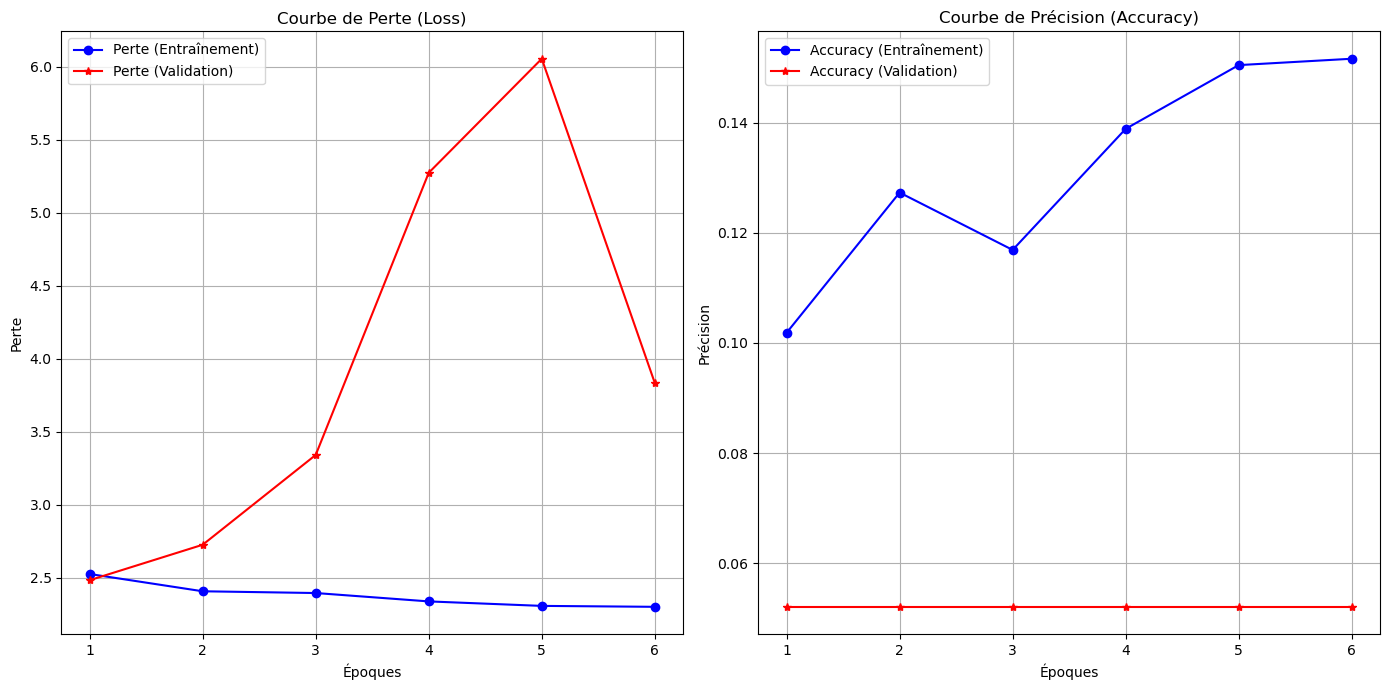

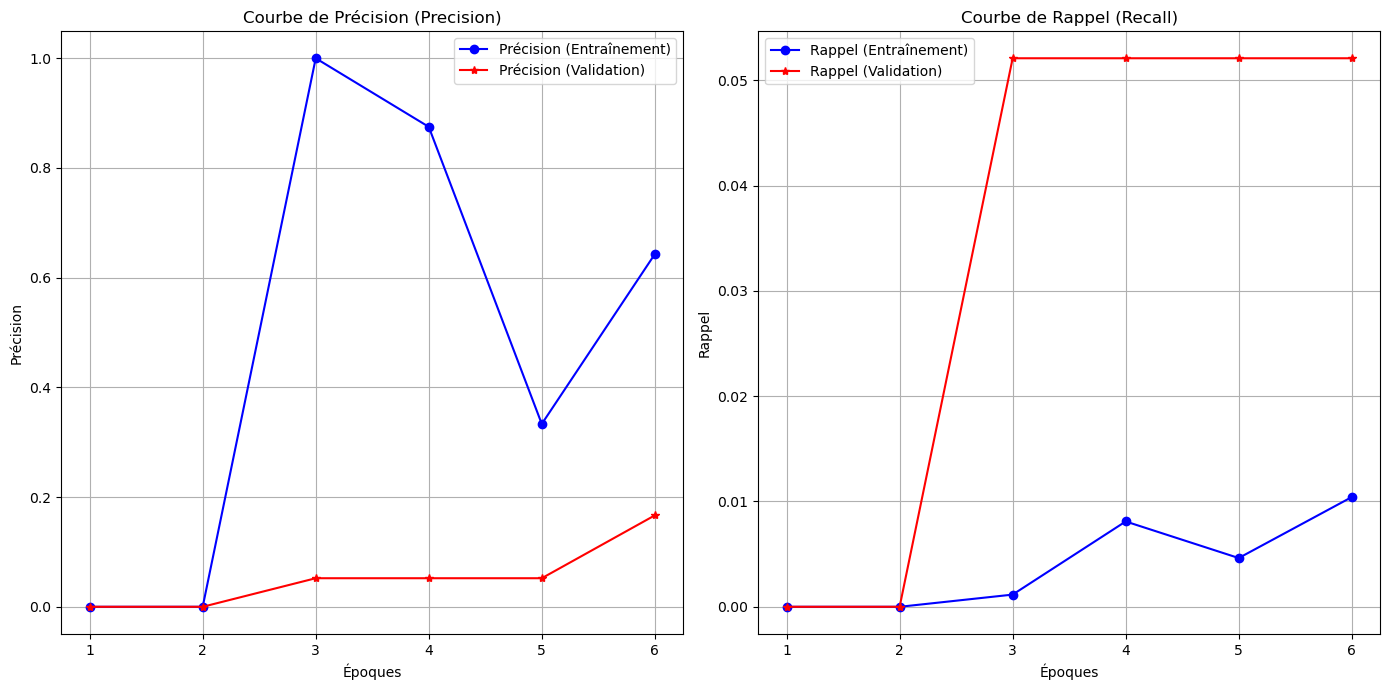

In [302]:
# (Assurez-vous que 'model', 'train', 'val', et 'param' sont définis)

# 1. Exécutez l'entraînement ET récupérez l'historique
print("Lancement de l'entraînement...")
validation_eval, trained_model, history = compile_and_fit(model, train, val, param)

print("\nÉvaluation finale sur le set de validation :", validation_eval)

# 2. Tracez les graphiques
print("Affichage des courbes d'apprentissage...")
plot_training_history(history)

### Fit tuning des hyperparamètres.

Après avoir défini les hyperparamètres modifiables et vérifier que les fonctions fonctionnent, il est temps de lancer l'optimisation des hyperparamètres. Pour cela je vous invite à utiliser Optuna [[3]](https://optuna.readthedocs.io/en/stable/index.html) qui a plusieurs fonctionnalités:
*   Une visualisation facilitée.
*   Un suivi de l'avancement de l'optimisation.
*   Une possibilité de reprendre l'optimisation sans reprendre depuis le début si un problème arrive durant le traitement.

 <font color=" Darkblue"> **Tips:** Essayez de lancer l'optimisation pendant le TP pour voir si il fonctionne et arretez le. Lancez le pour de bon à la fin de la séance ou pendant la semaine car cela va prendre plusieurs heures, voir plusieurs jours. </font>

 <font color="orange"> **Note anti-plagiat:** L'optimisation doit avoir une random seed fixe et différente pour chaque groupe. </font>

 Merci de justifier vos plages de valeurs et faite un résumé sous forme de tableau :
 > **Ecrire votre texte ici.**


 | Hyperparamètre | Meilleure valeur | Plage | Step | Type de la plage |
| :---------------- | :------: | :----: | :----: | :----: |
| -   |  -  | - | - | - |

In [303]:
# !pip install optuna

import optuna

SEED = 5
np.random.seed(SEED)

def objective(trial):

    # Exemple de paramètres à modifier
    param_model = {
        'activation': trial.suggest_categorical("activation", ["relu", "selu"]),
        'hidden_layer' : trial.suggest_int('hidden_layer', 1, 3)
    }

    param_training = {
        'max_epochs': trial.suggest_int('max_epochs', 800, 1000, step=100),
    }

    model = create_model(param_model)

    metrics, _ = compile_and_fit(model, train, val, param_training, verbose=0)

    trial.set_user_attr('Size', total_param(model))

    return metrics[1]


study_name = "NOM1~NOM2-Tuning"
storage_name = f'sqlite:////content/drive/MyDrive/TP N9EE39A/{study_name}.db' #Chemin à créer dans votre drive

study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    load_if_exists=True)

study.optimize(objective, n_trials=2)

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

## Résultat et discussion

<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  
![84%](https://progress-bar.dev/84)


### Export du modèle

Merci d'exporter le meilleur modèle et l'envoyer avec le jupyter notebook et la base de données d'entraînement. Lors de l'exportation d'un modèle, il est recommandé d'utiliser la base de donnée d'entrainement, et de validation.

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

In [ ]:
import joblib

study = optuna.load_study(storage=storage_name, study_name=study_name)
print("Best trial until now:")
print("   Value: ", study.best_trial.value)
print("   Params: ")
for key, value in study.best_trial.params.items():
    print(f"    -{key}: {value}")
print("----------------------")

model = create_model(study.best_trial.params)

train_and_val = tf.data.Dataset.from_tensor_slices((np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val))))
train_and_val = train_and_val.shuffle(1500, reshuffle_each_iteration=True)
train_and_val = train_and_val.batch(32, drop_remainder=True)


_, global_model = compile_and_fit(model, train_and_val, val, study.best_trial.params, verbose=0)

joblib.dump(global_model, '/content/drive/MyDrive/TP N9EE39A/NOM1~NOM2_model.pkl')

### Dépôt sur Kaggle

Il est temps de soumettre vos résultats sur Kaggle. Qu'en pensez vous, êtes vous satisfait de vos performances ? Est-ce que vous vous attendiez à ces performances ?

 <font color=" Darkblue"> **Tips:** Le format d'envoie et des tutoriels sont disponibles sur la page du concours. </font>

 <font color="orange"> **Note anti-plagiat:** Il est impossible que le fichier que vous allez déposer soit le même qu'un autre binôme. Le fichier sera regénérer lors de la correction et doit être similaire avec celui déposé. </font>

A la fin du projet, merci d'envoyer avec les autres fichiers ce fichier Kaggle avec comme nom **NOM1~NOM2_submission.csv**.

> **Ecrire votre texte ici.**

In [ ]:
#Ici, tous le code est à faire. Normalement, tous a déjà été codé ou est facilement trouvable sur internet et sur le site de la compétition !

### Visualisation des résultats

Ici tous le code a déjà été fait. Il faut par contre commenter les résultats et les performances que vous avez obtenu et l'utilité de chaque figure.

 #### Matrice de confusion

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

study = optuna.load_study(storage=storage_name, study_name=study_name)
model = create_model(study.best_trial.params)
_, model = compile_and_fit(model, train, val, study.best_trial.params, verbose=0)

y_prob= model.predict(val)
y_pred = y_prob.argmax(axis=1)

ds_labels=[]
for images, labels in val.unbatch():
    ds_labels.append(labels)
y_ref = np.array(ds_labels).argmax(axis=1)

label_names = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
ConfusionMatrixDisplay.from_predictions(y_ref, y_pred, cmap='Blues', normalize='true', ax=plt.subplots(figsize=(12,12))[1], display_labels=label_names)

#### Résultat du Fit-tuning

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
plt.figure(figsize=(12,12))
optuna.visualization.plot_optimization_history(study)

In [ ]:
plt.figure(figsize=(12,12))
optuna.visualization.plot_slice(study)

#### Influence des hyperparamètres sur les performances

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
result = optuna.importance.get_param_importances(study)
plt.figure(figsize=(12, 4.5), dpi=100)
names = list(result.keys())
values = list(result.values())

plt.bar(range(len(result)), np.array(values)*100, tick_label=names, color='#000233')
plt.ylabel("Hyperparameter importance (%)")
plt.show()

#### Influence des hyperparamètres sur le temps de calcul

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
result = optuna.importance.get_param_importances(study, target=lambda t: t.duration.total_seconds())
plt.figure(figsize=(12, 4.5), dpi=100)
names = list(result.keys())
values = list(result.values())

plt.bar(range(len(result)), np.array(values)*100, tick_label=names, color='#000233')
plt.ylabel("Hyperparameter importance (%)")
plt.show()

#### Frontière de Pareto [[4]](https://fr.wikipedia.org/wiki/Optimum_de_Pareto)

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
import pandas

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
  # From https://sirinnes.wordpress.com/2013/04/25/pareto-frontier-graphic-via-python/
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y)
    plt.xlabel("Poids du modèle (octets)")
    plt.ylabel("Accuracy (%)")
    plt.show()

df = study.trials_dataframe()
plot_pareto_frontier(df['user_attrs_Size'], df['value'])

## Allégement du modèle post-optimisation

Dans cette dernière partie, nous allons nous intéresser à l'influence des performances lorsque le modèle est allégé. Dans des appareils embarqués, il est nécessaire de trouver un compromis entre la performance du modèle, son poids, et la quantité d'opération.

Au vue du nombre de séances, nous allons nous intéressé ici qu'au poids du système.

Pour cela, vous allez essayé de réduire le poids du meilleur modèle obtenu, puis avoir un regard critique sur les performances à chaque modification.

Voici les techniques d'allégement à essayer:
  - **La quantification**: Réduire le nombre d'octets des paramètres du modèles et les convertir en entiers [[5]](https://www.tensorflow.org/lite/performance/post_training_quantization).
  - **L'élagage**: Supprimer les modèles qui ont un impact mineur sur les prédictions [[6]](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras).
  - **Le clustering**: Regrouper les poids de chaque couche dans un modèle en un nombre prédéfini de clusters, puis en partageant les valeurs centroïdes pour les poids appartenant à chaque cluster individuel [[7]](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example).
  - **La décimation** : Réduire le nombre d'entrée.

<font color=" Darkred"> Progression du TP après cette partie (environ 4h):

Essayez d'avoir la meilleure accuracy avec un poids maximum inférieur à 75 KB.

 <font color=" Darkblue"> **Tips:**  Des tutoriels sont disponibles sur les liens attachés au techniques d'allégement. </font>

 > **Ecrire votre texte ici.**

In [ ]:
#Ici, tous le code est à faire. Normalement, tous a déjà été codé ou est facilement trouvable sur internet !

### BONUS: Allégement avant optimisation

Relancez un fit-tuning en rajoutant les paramètres d'allégements. Puis, observez les resultats avec une frontière de pareto. Les valeurs minimums de poids de la frontière doivent se trouver en dessous de 50 KB.

 <font color=" Darkblue"> **Tips:** Utilisez 2 métriques lorsque vous lancez la fonction d'activation. </font>

 > **Ecrire votre texte ici.**

## Conclusion


 <font color=" Darkblue"> **Tips:** Concluez sur vos résultats, les limitations de votre modèle et les perspectives envisagées pour l'améliorer. </font>


 <font color=" Darkred"> Progression du TP après cette partie (environ 0h30): </font>  


> **Ecrire votre texte ici.**